# Import libraries and dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/Users/mananshah/Downloads/appdata10.csv')

In [8]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [9]:
df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

# Preprocessing the dataset

In [10]:
df['first_open'] = pd.to_datetime(df['first_open'])
df['enrolled_date'] = pd.to_datetime(df['enrolled_date'])

In [11]:
df['days_to_enroll'] = df['enrolled_date'] - df['first_open']

In [12]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,days_to_enroll
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaT,0,NaT
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaT,0,NaT
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaT,1,NaT
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0,0 days 00:03:03.159000
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1,0 days 00:05:49.180000


In [13]:
df.dtypes

user                              int64
first_open               datetime64[ns]
dayofweek                         int64
hour                             object
age                               int64
screen_list                      object
numscreens                        int64
minigame                          int64
used_premium_feature              int64
enrolled                          int64
enrolled_date            datetime64[ns]
liked                             int64
days_to_enroll          timedelta64[ns]
dtype: object

In [14]:
df['days_to_enroll'] = df['days_to_enroll'].dt.days

In [15]:
df.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                            object
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
days_to_enroll                 float64
dtype: object

In [16]:
print('Minimum days to enroll are: ', str(df['days_to_enroll'].min()))
print('Maximum days to enroll are: ', str(df['days_to_enroll'].max()))

Minimum days to enroll are:  0.0
Maximum days to enroll are:  226.0


<Axes: >

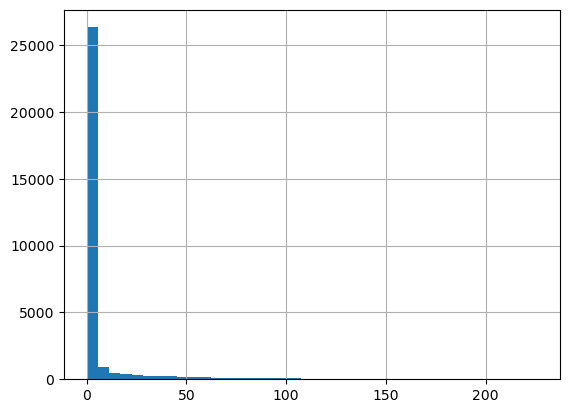

In [17]:
df['days_to_enroll'].hist(bins = 40)

In [18]:
df['upd_enroll'] = 0

In [19]:
#df.loc[(df['days_to_enroll']<61) & (df['enrolled'] == 1), 'upd_enroll'] = 1
df.upd_enroll = df.enrolled

In [20]:
# Check count of enrollment and non-enrollment in the dataset
df['upd_enroll'].value_counts()

upd_enroll
1    31074
0    18926
Name: count, dtype: int64

In [21]:
# Weekday or weekend does not impact
df.loc[:,['dayofweek', 'upd_enroll']].groupby(['dayofweek']).sum()

,upd_enroll
dayofweek,
0,4606
1,4315
2,3969
3,4258
4,4595
5,4685
6,4646


In [22]:
df.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked', 'days_to_enroll', 'upd_enroll'],
      dtype='object')

In [23]:
df.drop(columns = {'first_open', 'enrolled', 'enrolled_date', 'days_to_enroll'}, inplace = True)

In [24]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll
0,235136,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,1,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,0,1
4,51549,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1


In [25]:
#df['screen_list'] = df.screen_list.astype(str) + ','

In [26]:
df_top_screen = pd.read_csv('/Users/mananshah/Downloads/top_screens.csv')
top_screen = np.array(df_top_screen.loc[:, 'top_screens'])

In [27]:
for i in top_screen:
    df[i] = df.screen_list.str.contains(i).astype(int)
    df['screen_list'] = df.screen_list.str.replace(i + ',', '')

In [28]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll,...,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker
0,235136,3,02:00:00,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,254414,1,19:00:00,23,Loan,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,ReferralCon...",40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,51549,1,18:00:00,31,"joinscreen,ScanPreview,VerifySSN,Home,SelectIn...",32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.columns

Index(['user', 'dayofweek', 'hour', 'age', 'screen_list', 'numscreens',
       'minigame', 'used_premium_feature', 'liked', 'upd_enroll', 'Loan2',
       'location', 'Institutions', 'Credit3Container', 'VerifyPhone',
       'BankVerification', 'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry',
       'Cycle', 'idscreen', 'Credit3Dashboard', 'Loan3', 'CC1Category',
       'Splash', 'Loan', 'CC1', 'RewardsContainer', 'Credit3', 'Credit1',
       'EditProfile', 'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1',
       'Alerts', 'Saving8', 'Saving10', 'Leaderboard', 'Saving4',
       'VerifyMobile', 'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'L

In [30]:
df['non_top_screen_count'] = df.screen_list.str.count(',')

In [31]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,non_top_screen_count
0,235136,3,02:00:00,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19:00:00,23,Loan,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,ReferralCon...",40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18:00:00,31,"joinscreen,ScanPreview,VerifySSN,Home,SelectIn...",32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,9


In [32]:
df.drop(columns = {'screen_list', 'user'}, inplace = True)

In [33]:
df['hour'] = [x[0:3] for x in df.hour]

In [34]:
df.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,upd_enroll,Loan2,location,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,non_top_screen_count
0,3,02,23,15,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,7
1,6,01,24,13,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
2,1,19,23,3,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,16,28,40,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,6
4,1,18,31,32,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,9


In [35]:
df['hour'] = df['hour'].astype('int')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   dayofweek                50000 non-null  int64
 1   hour                     50000 non-null  int64
 2   age                      50000 non-null  int64
 3   numscreens               50000 non-null  int64
 4   minigame                 50000 non-null  int64
 5   used_premium_feature     50000 non-null  int64
 6   liked                    50000 non-null  int64
 7   upd_enroll               50000 non-null  int64
 8   Loan2                    50000 non-null  int64
 9   location                 50000 non-null  int64
 10  Institutions             50000 non-null  int64
 11  Credit3Container         50000 non-null  int64
 12  VerifyPhone              50000 non-null  int64
 13  BankVerification         50000 non-null  int64
 14  VerifyDateOfBirth        50000 non-null  int64
 15  Pr

In [ ]:
savings_screens = ["Saving1", "Saving2", "Saving2Amount", "Saving4", "Saving5", "Saving6","Saving7", "Saving8", "Saving9", "Saving10"];
df['SavingCount']=df[savings_screens].sum(axis=1);
df.drop(columns=savings_screens,axis=1,inplace=True);
credit_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"];
df['CreditCount']=df[credit_screens].sum(axis=1);
df.drop(columns=credit_screens,axis=1,inplace=True);
cc_screens = ["CC1", "CC1Category", "CC3"];
df['CCCount']=df[cc_screens].sum(axis=1);
df.drop(columns=cc_screens,axis=1,inplace=True);
loan_screens = ["Loan", "Loan2", "Loan3", "Loan4"];
df['LoanCount']=df[loan_screens].sum(axis=1);
df.drop(columns=loan_screens,axis=1,inplace=True);

In [ ]:
df.head()

# EDA

{'whiskers': [<matplotlib.lines.Line2D at 0x151a040d0>,
 'caps': [<matplotlib.lines.Line2D at 0x151a04610>,
 'boxes': [<matplotlib.lines.Line2D at 0x151a4bd90>,
 'medians': [<matplotlib.lines.Line2D at 0x151a04b50>,
 'fliers': [<matplotlib.lines.Line2D at 0x151a04df0>,
 'means': []}

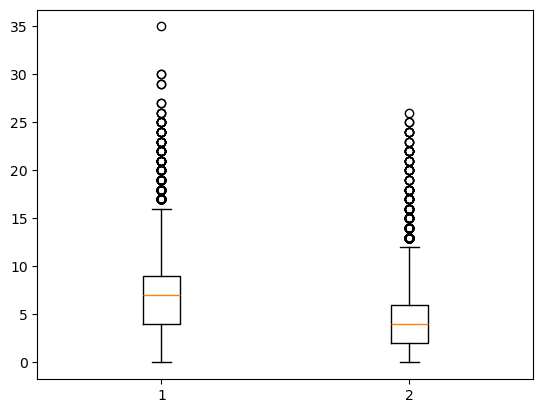

In [37]:
plt.boxplot([df.loc[df.upd_enroll == 1,'non_top_screen_count'], df.loc[df.upd_enroll == 0,'non_top_screen_count']])

{'whiskers': [<matplotlib.lines.Line2D at 0x155a857e0>,
 'caps': [<matplotlib.lines.Line2D at 0x155a85d20>,
 'boxes': [<matplotlib.lines.Line2D at 0x155a854b0>,
 'medians': [<matplotlib.lines.Line2D at 0x155a86260>,
 'fliers': [<matplotlib.lines.Line2D at 0x155a86500>,
 'means': []}

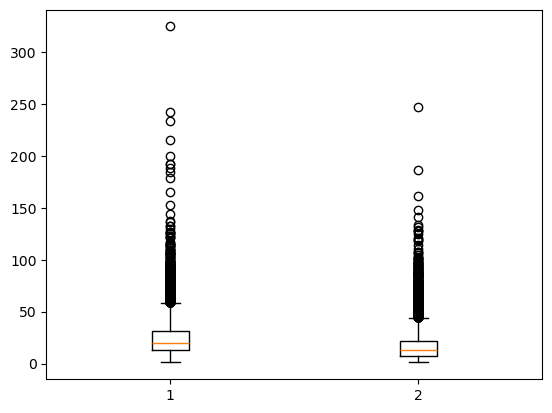

In [38]:
plt.boxplot([df.loc[df.upd_enroll == 1,'numscreens'], df.loc[df.upd_enroll == 0,'numscreens']])

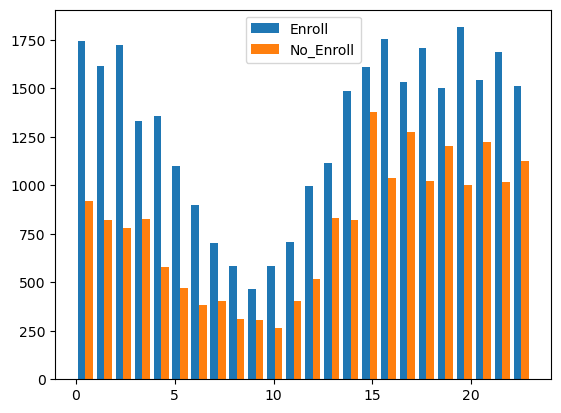

In [39]:
plt.hist([df.loc[df['upd_enroll']==1,:]['hour'], df.loc[df['upd_enroll']==0,:]['hour']],bins = 24)
plt.legend(['Enroll', 'No_Enroll'])

In [40]:
df.used_premium_feature.value_counts()

used_premium_feature
0    41399
1     8601
Name: count, dtype: int64

In [41]:
df.minigame.value_counts()

minigame
0    44609
1     5391
Name: count, dtype: int64

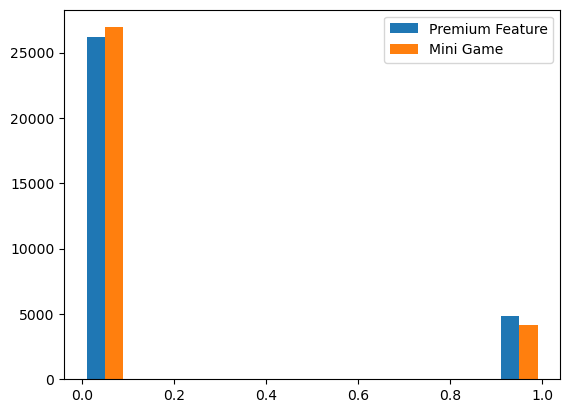

In [42]:
plt.hist([df.loc[df['upd_enroll']==1 ,:]['used_premium_feature'], df.loc[df['upd_enroll']==1,:]['minigame']])
plt.legend(['Premium Feature', 'Mini Game'])

# Create training and testing dataset

In [45]:
# Creating input dataset
X = df.drop(['upd_enroll'],axis = 1)

In [46]:
# Creating output dataset
y = df['upd_enroll']

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_Scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_Scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

# XGBoost Model

In [50]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

params = {
            'objective':'binary:logistic',
            'max_depth': 20,
            'alpha': 1,
            'learning_rate': 1.0,
            'n_estimators':1000
        }  

model = XGBClassifier(**params)
model.fit(X_train_Scaled, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [104]:
y_pred = model.predict(X_test_Scaled)

Accuracy = 0.70
Recall = 0.78
Precision = 0.74


<Axes: title={'center': 'Confusion Matrix on entire dataset'}>

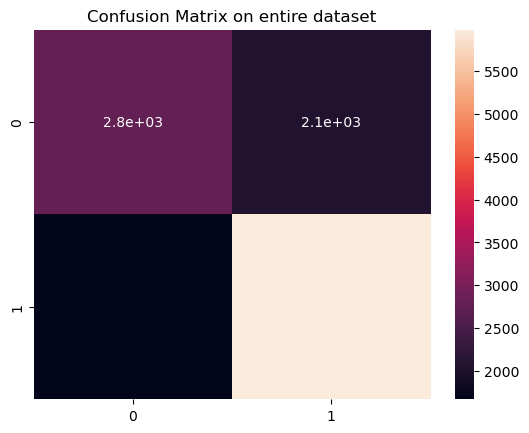

In [106]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}')
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.title('Confusion Matrix on entire dataset')
sns.heatmap(cm, annot = True)

In [108]:
import sklearn.metrics as metrics
print(metrics.roc_auc_score(y_test, y_pred))

0.6793816843870921


In [111]:
y_pred_train = model.predict(X_train_Scaled)

Accuracy = 1.00
Recall = 1.00
Precision = 1.00


<Axes: title={'center': 'Confusion Matrix on entire dataset'}>

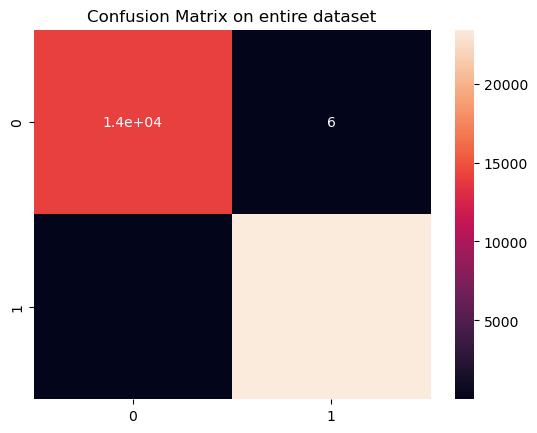

In [113]:
print(f'Accuracy = {accuracy_score(y_train, y_pred_train):.2f}\nRecall = {recall_score(y_train, y_pred_train):.2f}\nPrecision = {precision_score(y_train, y_pred_train):.2f}')
cm = confusion_matrix(y_train, y_pred_train)
plt.figure()
plt.title('Confusion Matrix on entire dataset')
sns.heatmap(cm, annot = True)

In [115]:
print (metrics.roc_auc_score(y_train,y_pred_train))

0.9997442332699326


In [117]:
from sklearn.model_selection import cross_validate
params = {
            'objective':'binary:logistic',
            'max_depth': 20,
            'alpha': 1,
            'learning_rate': 1.0,
            'n_estimators':1000
        }  
model_cv = XGBClassifier(**params)
cv_score = cross_validate(model, X_train_Scaled, y_train, cv=10, scoring = 'accuracy', return_train_score = True)
cv_score

{'fit_time': array([1.32791209, 1.13393807, 1.4759469 , 1.08815908, 1.06832314,
        1.13417912, 1.04650402, 1.18825603, 1.11726999, 1.2228229 ]),
 'score_time': array([0.020468  , 0.01668596, 0.02566576, 0.01489282, 0.01647997,
        0.01868224, 0.0178051 , 0.01787496, 0.01911688, 0.02217293]),
 'test_score': array([0.7616    , 0.77066667, 0.77386667, 0.75253333, 0.7656    ,
        0.76426667, 0.76746667, 0.77146667, 0.752     , 0.75253333]),
 'train_score': array([0.99979259, 0.99979259, 0.99985185, 0.99976296, 0.99988148,
        0.99979259, 0.99982222, 0.99982222, 0.99979259, 0.99973333])}

In [119]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 1,
            'learning_rate': 0.3,
            'n_estimators':100
        }  

model = XGBClassifier(**params)
model.fit(X_train_Scaled, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [122]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 1,
            'learning_rate': 0.3,
            'n_estimators':100
        }   
model_cv = XGBClassifier(**params)
cv_score = cross_validate(model, X_train_Scaled, y_train, cv=5, scoring = 'accuracy', return_train_score = True)
cv_score

{'fit_time': array([0.16884995, 0.10001206, 0.10274887, 0.1109519 , 0.17140627]),
 'score_time': array([0.00696802, 0.00637221, 0.00645781, 0.00687099, 0.00967288]),
 'test_score': array([0.78653333, 0.7892    , 0.78426667, 0.78413333, 0.78253333]),
 'train_score': array([0.80906667, 0.80593333, 0.80666667, 0.8083    , 0.81036667])}

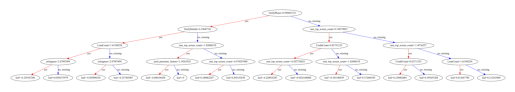

In [135]:
from xgboost import plot_tree
import graphviz

plot_tree(model, figsize=(20,12))
plt.show()

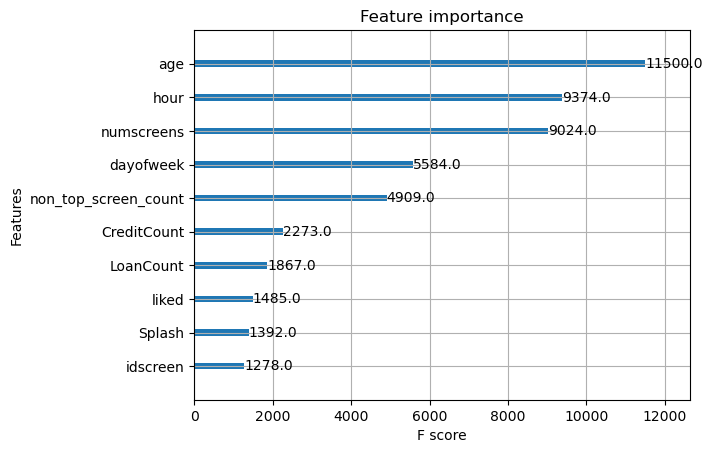

<Figure size 2000x2000 with 0 Axes>

In [558]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=10)
plt.figure(figsize = (20, 20))
plt.show()

In [139]:
import xgboost as xgb

help(xgb.XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |  
 |      max_depth :  typing.Optional[int]
 |  
 |          Maximum tree depth for base learners.
 |  
 |      max_leaves : typing.Optional[int]
 |  
 |          Maximum number of leaves; 0 indicates no limit.
 |  
 |      max_bin : typing.Optional[int]
 |  
 |          If using histogram-based algorithm, maximum number of bins per feature
 |  
 |      grow_policy : typing.Optional[str]
 |  
 |          Tree growing policy.
 |  
 |   

In [143]:
from bayes_opt import BayesianOptimization
help(BayesianOptimization.maximize)

Help on function maximize in module bayes_opt.bayesian_optimization:

maximize(self, init_points: 'int' = 5, n_iter: 'int' = 25) -> 'None'
    Maximize the given function over the target space.
    
    Parameters
    ----------
    init_points : int, optional(default=5)
        Number of random points to probe before starting the optimization.
    
    n_iter: int, optional(default=25)
        Number of iterations where the method attempts to find the maximum
        value.
    
    Warning
    -------
        The maximize loop only fits the GP when suggesting a new point to
        probe based on the acquisition function. This means that the GP may
        not be fitted on all points registered to the target space when the
        method completes. If you intend to use the GP model after the
        optimization routine, make sure to fit it manually, e.g. by calling
        ``optimizer._gp.fit(optimizer.space.params, optimizer.space.target)``.

